In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import numpy as np
import scipy.io as sio
import random
import matplotlib.pyplot as plt
import os
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

In [2]:
#  https://blog.csdn.net/ljyljyok/article/details/107619881  这里是解决这个问题，貌似这个问题指挥出现在LSTM中
# https://blog.csdn.net/weixin_44545603/article/details/103322446?utm_medium=distribute.pc_relevant.none-task-blog-OPENSEARCH-1.nonecase&depth_1-utm_source=distribute.pc_relevant.none-task-blog-OPENSEARCH-1.nonecase
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 一、导入数据加数据处理阶段

In [3]:
# 导入数据
path = os.path.join("E:\Eric_HSI\hyperspectral_datasets")
PaviaU = os.path.join(path,'paviaU.mat')
PaviaU_gt = os.path.join(path,'paviaU_gt.mat')
method_path = 'SVM'

In [4]:
# 加载数据，返回值为一个字典内嵌ndarray的数据结构
data = sio.loadmat(PaviaU)
data_gt = sio.loadmat(PaviaU_gt)
data = data['data']  # im为样本点的光谱值的ndarray
data_label = data_gt['groundT']  # imGIS样本点的标签值组成的ndarray

In [5]:
# 归一化，这个归一化的方法有点不一样
data = (data - float(np.min(data)))
data = data/np.max(data)

In [6]:
data.shape  # (610, 340, 103)
data_label.shape  # (610, 340)

(610, 340)

In [7]:
# 参数设置
# 训练数据集的个数200, deepth为通道数103，class为类别数 paviaU 为 9
sample_num = 200
deepth = data.shape[2]
classes = np.max(data_label)
classes

9

In [8]:
# 创建三个字典,用处留在下一步说明
data_pos = {}
train_pos = {}
test_pos = {}

for i in range(1,classes+1):
    data_pos[i] = []
    train_pos[i] = []
    test_pos[i] = []
data_pos

{1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}

In [9]:
# 构造一个总的data_pos
num = 0
for i in range(data_label.shape[0]):
    for j in range(data_label.shape[1]):
        if data_label[i][j] == 0:
           num += 1
num  

164624

In [10]:
# 统计每一个类的集合
# 得到{1类：对应点坐标位置列表，2类：对应的坐标位置列表；等等}
# 这里的 Class + 1 是因为有背景 
# pos  ->  position

# 构造一个总的data_pos
for i in range(data_label.shape[0]):
    for j in range(data_label.shape[1]):
        for k in range(1,classes+1):     # 这里类别从1开始，把背景像素直接删除了
            # 统计每一个类的集合
            if data_label[i,j]==k:
                data_pos[k].append([i,j])
                continue

In [11]:
# 查看每一个类的坐标值
# 取出键为1的 ndarray 中的前10个数，也就是标签为1的前10个像素是位置坐标位置
data_pos[1][:10]

[[0, 91],
 [0, 92],
 [0, 93],
 [0, 94],
 [0, 95],
 [0, 96],
 [0, 97],
 [0, 98],
 [0, 112],
 [0, 113]]

In [12]:
# for k,v in data_pos.items():
#     print(len(v))

In [13]:
# 取出测试集和训练集,此过程后训练集和测试集为字典，和上面构造data_pos类似
# 返回值也是字典，字典的内容一个是包含200 * class 的训练集和剩余的测试集
for i in range(1,classes+1):
    # 随机生成 200 个不重复的index，用于生成训练集和测试集
    indexies = random.sample(range(len(data_pos[i])),sample_num)
    for k in range(len(data_pos[i])):
        if k not in indexies:
            test_pos[i].append(data_pos[i][k])
        else:
            train_pos[i].append(data_pos[i][k])

In [14]:
# for k,v in test_pos.items():
#     print(len(v))

In [15]:
train_pos[1][:10]

[[1, 98],
 [3, 112],
 [4, 109],
 [6, 112],
 [11, 101],
 [15, 103],
 [16, 104],
 [18, 111],
 [21, 91],
 [24, 84]]

In [16]:
print(len(train_pos))  # 9
print(len(train_pos[2]))  # 200
type(train_pos[1][:10])  # list
print(type(train_pos))
# type(train_pos[1]) # list
row, col = train_pos[1][0]  # list可以这样取值
row

9
200
<class 'dict'>


1

In [17]:
# dict train_pos change to list train, but list include n ndarray
# 将位置信息转化光谱值信息，即将坐标值转化为其对应的光谱值，此过程得到一个为列表
# 准确的说是列表内嵌套ndarray的结构，ndarray有 1 维，个数103
train = []   # 训练样本的总个数，每个类别分别有200个样本,每个样本103维，总共有1800个样本
train_label = []
test = []
test_label = []

# 训练集生成
for i in range(1,len(train_pos)+1):   # 9 classes + bacground 
    for j in range(len(train_pos[i])):   # 200个样本
        row,col = train_pos[i][j]
        train.append(data[row,col])   #### 一下子传入103维 ####
        train_label.append(i)

# 测试集生成
for i in range(1,len(test_pos)+1):
    for j in range(len(test_pos[i])):
        row,col = test_pos[i][j]
        test.append(data[row,col])
        test_label.append(i)

In [18]:
type(train)   # list 1800
type(train[1])  # ndarray

numpy.ndarray

### np.array & np.asarray
- array和asarray都可以将结构数据转化为ndarray，
- 但是主要区别就是当数据源是ndarray时，array仍然会copy出一个副本，占用新的内存，但asarray不会。

In [19]:
train = np.asarray(train)
train_label = np.asarray(train_label)
print(train.shape)
print(train_label.shape)
train = train.reshape(train.shape[0], train.shape[1], 1) 
print(train.shape)
test = np.asarray(test)
test_label = np.asarray(test_label)
test = test.reshape(test.shape[0], test.shape[1], 1) 
print(test.shape)
print(test_label.shape)

(1800, 103)
(1800,)
(1800, 103, 1)
(40976, 103, 1)
(40976,)


In [20]:
# 标签值-1
test_label = test_label - 1
train_label = train_label - 1

In [21]:
if not os.path.exists('./np_data'):
    os.makedirs('./np_data')

In [22]:
# 保存数据
path_train = r"E:\Eric_HSI\excise4\np_data\train" + ".npy"
path_train_label = r"E:\Eric_HSI\excise4\np_data\train_label" + ".npy"
path_test = r"E:\Eric_HSI\excise4\np_data\test" + ".npy"
path_test_label = r"E:\Eric_HSI\excise4\np_data\test_label" + ".npy"


np.save(path_train, train)
np.save(path_train_label, train_label)
np.save(path_test, test)
np.save(path_test_label, test_label)

In [23]:
train_label = tf.keras.utils.to_categorical(train_label)
test_label = tf.keras.utils.to_categorical(test_label)

In [24]:
test_label[1].shape

(9,)

In [25]:
# LSTM 擅长根据时间变化的预测趋势问题
# model = keras.Sequential()
# model.add(layers.LSTM(32, input_shape=(train.shape[1:])))
# model.add(layers.Dense(10))

model = keras.Sequential()
model.add(layers.LSTM(64, input_shape=(train.shape[1:]), return_sequences=True))
model.add(layers.LSTM(64, return_sequences=True))
# model.add(layers.LSTM(64))
model.add(layers.Flatten())
model.add(layers.Dense(9, activation='softmax'))

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['acc'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 103, 64)           16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 103, 64)           33024     
_________________________________________________________________
flatten (Flatten)            (None, 6592)              0         
_________________________________________________________________
dense (Dense)                (None, 9)                 59337     
Total params: 109,257
Trainable params: 109,257
Non-trainable params: 0
_________________________________________________________________


In [28]:
# checkpoint_path = "./weights/cp.ckpt"
# if not os.path.exists('./weights'):
#     os.makedirs('./weights')
# checkpoint_dir = os.path.dirname(checkpoint_path)          # 获取文件夹名称

In [29]:
# 创建一个保存模型权重的回调
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                  save_weights_only=True,
#                                                  save_best_only=True,
#                                                  period=3,  # 每5次保存一次
#                                                  verbose=1)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=0.000001, verbose=1)

In [30]:
BATCH_SIZE = 64

In [31]:
history = model.fit(train, 
                    train_label, 
                    batch_size=BATCH_SIZE, 
                    epochs=100, 
                    validation_data=(test, test_label),
                    callbacks=[lr])

Epoch 1/100
29/29 [==============================] - 3s 103ms/step - loss: 2.1585 - acc: 0.1461 - val_loss: 2.1543 - val_acc: 0.0297
Epoch 2/100
29/29 [==============================] - 2s 81ms/step - loss: 1.9808 - acc: 0.2444 - val_loss: 1.9349 - val_acc: 0.1629
Epoch 3/100
29/29 [==============================] - 2s 81ms/step - loss: 1.4696 - acc: 0.4333 - val_loss: 1.4559 - val_acc: 0.2907
Epoch 4/100
29/29 [==============================] - 2s 81ms/step - loss: 1.1364 - acc: 0.4894 - val_loss: 1.2305 - val_acc: 0.3898
Epoch 5/100
29/29 [==============================] - 2s 81ms/step - loss: 1.0118 - acc: 0.5528 - val_loss: 1.0718 - val_acc: 0.5881
Epoch 6/100
29/29 [==============================] - 2s 81ms/step - loss: 0.8989 - acc: 0.6328 - val_loss: 1.0634 - val_acc: 0.5159
Epoch 7/100
29/29 [==============================] - 2s 81ms/step - loss: 0.8127 - acc: 0.6578 - val_loss: 1.0007 - val_acc: 0.5591
Epoch 8/100
29/29 [==============================] - 2s 81ms/step - loss: 0

In [39]:
if not os.path.exists('./weights'):
    os.makedirs('./weights')

In [40]:
# 保存权重
model.save_weights('./weights/weight.ckpt')

In [41]:
# if not os.path.exists('./model'):
#     os.makedirs('./model')

In [42]:
# 画出图片
# from tensorflow.keras.utils import plot_model
# plot_model(model, to_file='./model/model.png', show_shapes=True)

In [43]:
# 读取画出的图片
# show the model figure
# model_img = plt.imread('./model/model.png')
# plt.figure(dpi=180)
# plt.imshow(model_img)
# plt.show()

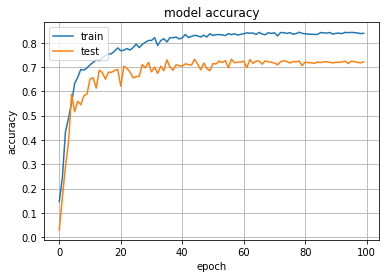

In [44]:
# summarize history for accuracy
plt.plot(history.epoch, history.history['acc'])
plt.plot(history.epoch, history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid(True)
plt.legend(['train', 'test'], loc='upper left') 
# plt.savefig("./result/model_accuracy_100.svg")
plt.show()

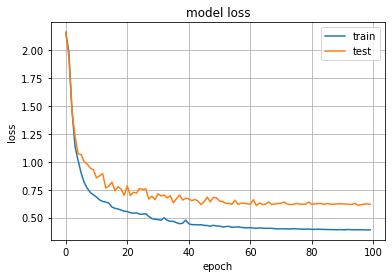

In [45]:
# summarize history for loss 
plt.plot(history.epoch, history.history['loss'])
plt.plot(history.epoch, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid(True)
plt.legend(['train', 'test'], loc='upper right') 
# plt.savefig("./result/model_loss_100.svg")
plt.show()